## The effect of mixing geometry on evolution

This notebook examines the effect of mixing geometry on evolutionary rate. We consider a hypercube sea of individuals, where each axis mixes at a different rate. Is it better for all axes to mix at the same rate (i.e. all slowly or all rapidly), or is it better for some axes to mix at different rates than other axes?

In [1]:
import math
from types import SimpleNamespace

import matplotlib.pyplot as plt
import tqdm
import torch

In [2]:
def migrate(args, pangenome: torch.Tensor) -> torch.Tensor:
    """
    Creates a similarly shaped pangenome with each cell replaced by a nearby cell.
    """
    # Create a gradation of mixing along dimensions of a hypercube.
    assert 0 < args.min_migration_rate <= args.max_migration_rate < 1
    per_dim_rate = torch.linspace(
        math.log(args.min_migration_rate),
        math.log(args.max_migration_rate),
        args.dimension,
    ).exp()

    # Randomly migrate along each dimension.
    N = len(pangenome)
    index = torch.arange(N)
    for i, rate in enumerate(per_dim_rate):
        index ^= (torch.rand(N) < rate).long() << i
    return pangenome[index]

In [3]:
def mutate(args, pangenome: torch.Tensor) -> None:
    """
    Randomly flips bits in-place.
    """
    N = len(pangenome)
    for i in range(64):
        pangenome ^= (torch.rand(N) < args.mutation_rate).long() << i

In [4]:
def crossover(child: torch.tensor, parent: torch.tensor):
    assert child.shape == parent.shape
    mask = (-2 ** 63) >> torch.randint(64, child.shape)
    mask = torch.where(torch.empty(child.shape).bernoulli_().bool(), mask, ~mask)
    child &= ~mask
    child |= mask & parent

In [5]:
gene_sizes = [4, 5, 6, 7, 8, 4, 5, 6, 7, 8, 4]
assert sum(gene_sizes) == 64, sum(gene_sizes)
genes = []
begin = 0
for gene_size in gene_sizes:
    gene = (2 ** gene_size - 1) << begin
    if gene >= 2 ** 63:
        gene -= 2 ** 64
    genes.append(gene)
    begin += gene_size
genes = torch.tensor(genes)
print(f"Created {len(genes)} genes")

Created 11 genes


In [6]:
def get_fitness(genome: torch.Tensor):
    masked = genome[..., None] & genes
    return masked.eq(0).float().sum(-1) + 2 * masked.eq(genes).float().sum(-1)

In [7]:
def init(args) -> dict:
    pangenome = torch.zeros(2 ** args.dimension, dtype=torch.long)
    fitness = get_fitness(pangenome)
    return {"pangenome": pangenome, "fitness": fitness}

In [8]:
def step(args, state: dict) -> None:
    pangenome = migrate(args, state["pangenome"])
    mutate(args, pangenome)
    crossover(pangenome, state["pangenome"])
    fitness = get_fitness(pangenome)
    probs = (fitness - state["fitness"]).sigmoid()
    selected = torch.bernoulli(probs).bool()
    state["pangenome"] = torch.where(selected, pangenome, state["pangenome"])
    state["fitness"] = torch.where(selected, fitness, state["fitness"])

In [9]:
def solve(args):
    state = init(args)
    best = [state["fitness"].max().item()]
    mean = [state["fitness"].mean().item()]
    for t in tqdm.tqdm(range(args.num_steps)):
        step(args, state)
        best.append(state["fitness"].max().item())
        mean.append(state["fitness"].mean().item())
    return {
        "best": torch.tensor(best),
        "mean": torch.tensor(mean),
        "final": state["fitness"],
        "final_best": state["fitness"].max().item(),
    }

In [10]:
args = SimpleNamespace(
    dimension=14,
    min_migration_rate=0.01,
    max_migration_rate=0.5,
    mutation_rate=1 / 64,
    num_steps=1000,
)
solution = solve(args)
print(solution["final_best"])

100%|██████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.77it/s]

15.0


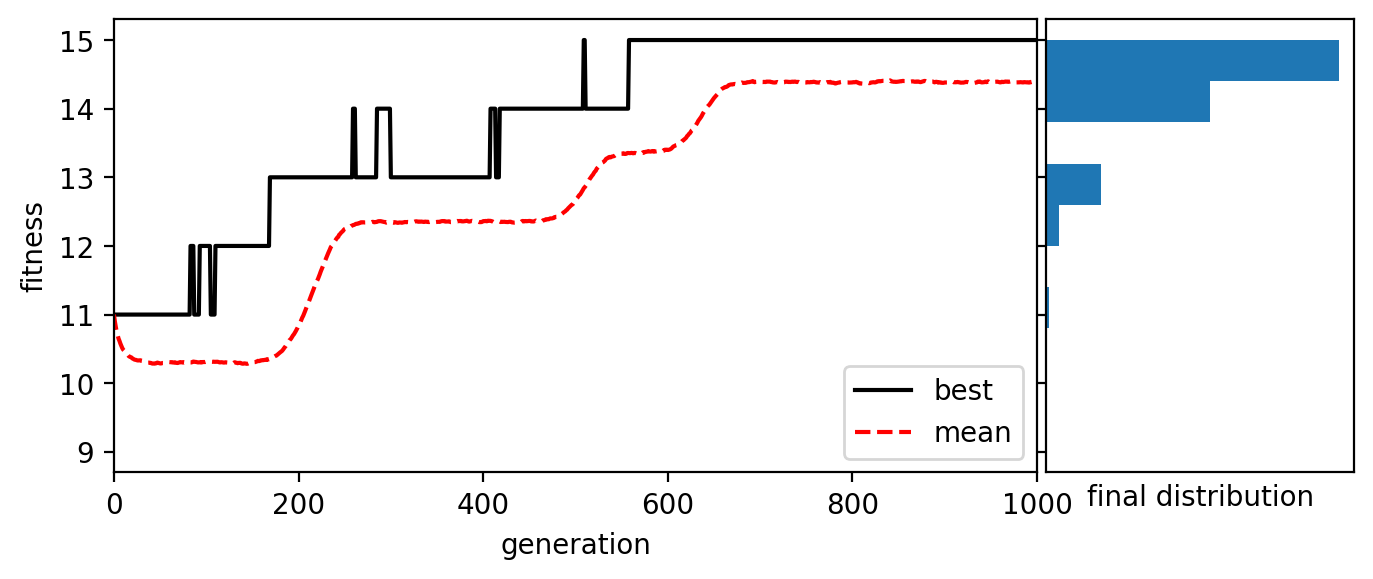

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True,
                         gridspec_kw={"width_ratios": [3, 1]}, dpi=200)
fig.patch.set_color("white")
axes[0].plot(solution["best"], "k-", label="best")
axes[0].plot(solution["mean"], "r--", label="mean")
axes[0].set_ylabel("fitness")
axes[0].set_xlabel("generation")
axes[0].set_xlim(0, len(solution["best"]) - 1)
axes[0].legend(loc="lower right")
axes[1].hist(solution["final"].numpy(), orientation="horizontal")
axes[1].set_xlabel("final distribution")
axes[1].set_xticks(())
plt.subplots_adjust(wspace=0.015)